# M0810 | Project - Part 1



### Data Collection

Collect data from external files

In [1]:
import numpy as np

seismic_data_filename = "F3_train.npy"
seismic_facies_filename = "F3_train_labels.npy"
seismic_attr_instantaneous_frequency_filename = "F3_train_instantaneous_frequency.npy"
seismic_attr_cosine_instantaneous_phase_filename = "F3_train_cosine_instantaneous_phase.npy"
seismic_attr_envelope_filename = "F3_train_envelope.npy"

#def filter_data(data): return data
#def filter_data(data): return data[:,400:701,100:250] 
#def filter_data(data): return data[:10,500:701,200:250] 
def filter_data(data): return data[:200,500:701,150:250] 

# Read the seismic data samples from a NPY file
seismic_data   = filter_data(np.load(seismic_data_filename))
seismic_labels = filter_data(np.load(seismic_facies_filename))
seismic_inst_freq = filter_data(np.load(seismic_attr_instantaneous_frequency_filename))
seismic_cos_inst_phase = filter_data(np.load(seismic_attr_cosine_instantaneous_phase_filename))
seismic_envelope = filter_data(np.load(seismic_attr_envelope_filename))

print("type(seismic_data):", type(seismic_data))
print("seismic_data.shape:", seismic_data.shape)
print("seismic_data.dtype:", seismic_data.dtype)
print("This seismic data contains", seismic_data.shape[0], "inlines."
      " Each inline contains",seismic_data.shape[1],
      "seismic traces, each one with", seismic_data.shape[2], "samples.")

type(seismic_data): <class 'numpy.ndarray'>
seismic_data.shape: (200, 201, 100)
seismic_data.dtype: float64
This seismic data contains 200 inlines. Each inline contains 201 seismic traces, each one with 100 samples.


### Data Visualization
Plot graphic of the seismic_data and seismic_inst_freq, seismic_cos_inst_phase, seismic_envelope
Goal: understand the possible types of regression to choose the best models to train.

In [2]:
def printData(name, data):
    print(name, ":", data.shape)

printData("seismic_data", seismic_data)
printData("seismic_inst_freq", seismic_inst_freq)
printData("seismic_cos_inst_phase", seismic_cos_inst_phase)
printData("seismic_envelope", seismic_envelope)

seismic_data : (200, 201, 100)
seismic_inst_freq : (200, 201, 100)
seismic_cos_inst_phase : (200, 201, 100)
seismic_envelope : (200, 201, 100)


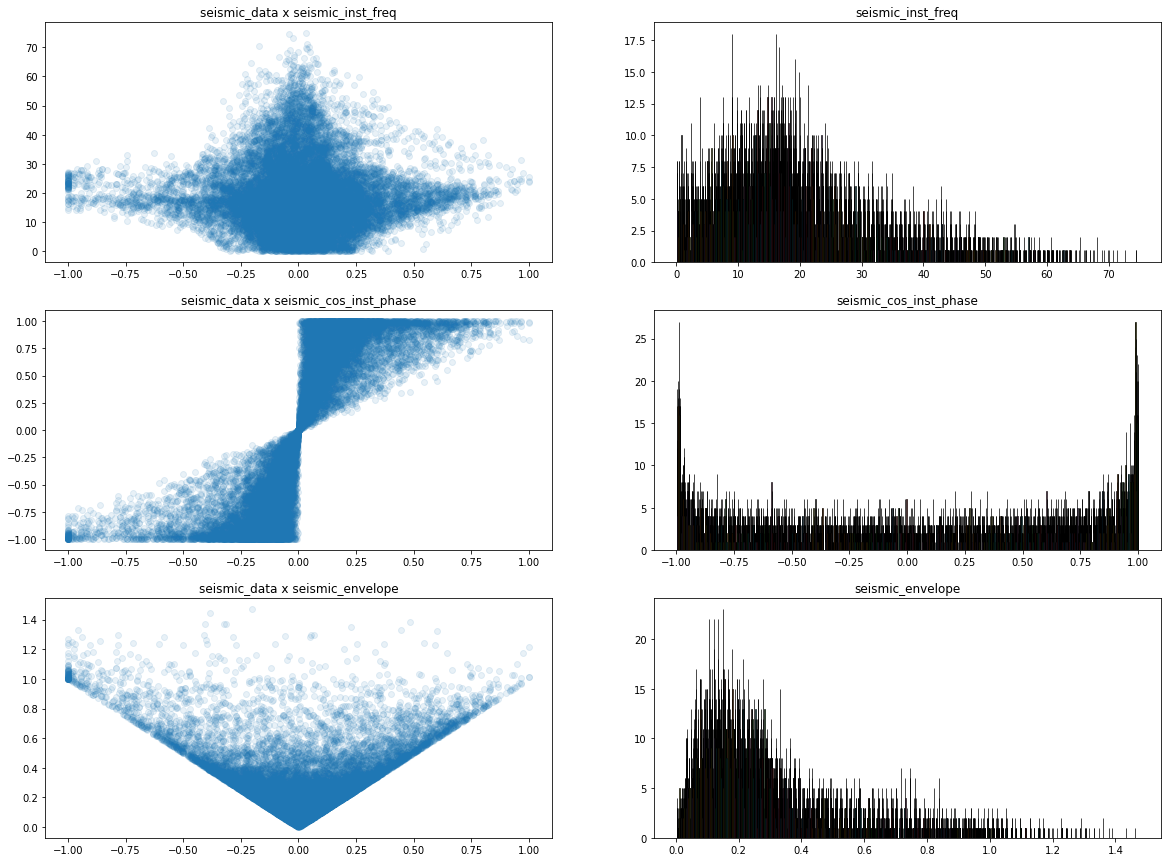

In [3]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows = 3, ncols = 2, figsize = (20, 15))

#seismic_inst_freq
ax[0, 0].set_title('seismic_data x seismic_inst_freq')
ax[0, 0].scatter(seismic_data[0], seismic_inst_freq[0], alpha = 0.1)
ax[0, 1].set_title('seismic_inst_freq')
ax[0, 1].hist(seismic_inst_freq[0], bins=100, edgecolor='k', alpha=0.7)

#seismic_cos_inst_phase
ax[1, 0].set_title('seismic_data x seismic_cos_inst_phase')
ax[1, 0].scatter(seismic_data[0], seismic_cos_inst_phase[0], alpha = 0.1)
ax[1, 1].set_title('seismic_cos_inst_phase')
ax[1, 1].hist(seismic_cos_inst_phase[0], bins=100, edgecolor='k', alpha=0.7)

#seismic_envelope
ax[2, 0].set_title('seismic_data x seismic_envelope')
ax[2, 0].scatter(seismic_data[0], seismic_envelope[0], alpha = 0.1)
ax[2, 1].set_title('seismic_envelope')
ax[2, 1].hist(seismic_envelope[0], bins=100, edgecolor='k', alpha=0.7)

plt.show()

In [3]:
import matplotlib.pyplot as plt

# Inline number
inline = 0

#Plot seismic facies
def plotFacies(seismic_labels, cmap, title = "Seismic Facies"):
    
    #Transposing the data to make visualization more natural
    panel = seismic_labels[0,:,:].T 
    
    #Plot graphics
    plt.imshow(panel, cmap = cmap, interpolation='nearest')
    plt.title(title)
    plt.colorbar()
    plt.show()

In [4]:
import pandas as pd

#From a 3-dimensional dataset, add 4th dimension with neighbors'value
def neighbors_4(data):
    
    print("Data shape before: ", data.shape)
    
    neighbors = np.zeros([data.shape[0], data.shape[1], data.shape[2], 5])
    
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            for k in range(data.shape[2]):
                    
                neighbors[i, j, k, 0] = data[i, j, max(k-2, 0)]
                neighbors[i, j, k, 1] = data[i, j, max(k-1, 0)]
                neighbors[i, j, k, 2] = data[i, j, k]
                neighbors[i, j, k, 3] = data[i, j, min(k+1, data.shape[2] - 1)]
                neighbors[i, j, k, 4] = data[i, j, min(k+2, data.shape[2] - 1)]
                
    neighbors = neighbors.reshape(-1, neighbors.shape[-1])
    print("Neighbors shape: ", neighbors.shape)
    
    df = pd.DataFrame(neighbors)
    print(df)
    
    return df

----

## CASE 1 | Instantaneous frequency

### Data Preprocessing
Split seismic_data and seismic_inst_freq into train and test sets

In [5]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(seismic_data,
                                                    seismic_inst_freq,
                                                    random_state = 48,
                                                    test_size = 0.25)

### Feature Selection

Create 4 more features with the values from the neighbors.
Cut the data in the center to remove the edges. Try without and with padding later.

In [6]:
#Create a dataframe with the 4 neighbors of the seismic trace and reshape to 1D and 5 features
data_train = neighbors_4(x_train)

#Reshape labels array to 1D
label_train = y_train.reshape(-1)
print("label_train:", label_train.shape)

Data shape before:  (150, 201, 100)
Neighbors shape:  (3015000, 5)
                0         1         2         3         4
0       -0.008620 -0.008620 -0.008620  0.087573  0.255171
1       -0.008620 -0.008620  0.087573  0.255171  0.417836
2       -0.008620  0.087573  0.255171  0.417836  0.469510
3        0.087573  0.255171  0.417836  0.469510  0.352117
4        0.255171  0.417836  0.469510  0.352117  0.139526
...           ...       ...       ...       ...       ...
3014995  0.040616  0.171763  0.430611  0.697784  0.800067
3014996  0.171763  0.430611  0.697784  0.800067  0.647740
3014997  0.430611  0.697784  0.800067  0.647740  0.354212
3014998  0.697784  0.800067  0.647740  0.354212  0.354212
3014999  0.800067  0.647740  0.354212  0.354212  0.354212

[3015000 rows x 5 columns]
label_train: (3015000,)


### Feature Scaling

In [7]:
from sklearn.preprocessing import MinMaxScaler

#Define min max scaler
scaler = MinMaxScaler()                          

#Transform data
data_train = scaler.fit_transform(data_train)

### ML Model

Linear Regression


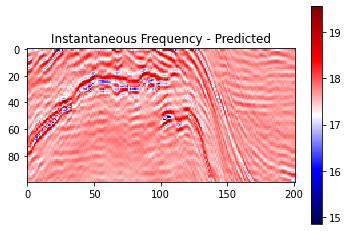

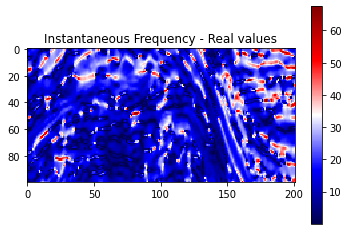

Best Parameters: {'fit_intercept': True}
Best Score: -0.0010252641545039688


In [9]:
import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

#Select a linear model
model = LinearRegression()
print("Linear Regression")

# Define the parameter grid
param_grid = {'fit_intercept': [True, False]}

# Initialize GridSearchCV with the model and parameter grid
grid_search_C1M1 = GridSearchCV(estimator = model,
                           param_grid = param_grid,
                           scoring = 'r2',
                           cv = 5)

# Fit the GridSearchCV to the data
grid_search_C1M1.fit(data_train, label_train)
joblib.dump(grid_search_C1M1.best_estimator_, "Regression - C1M1.sav")

# Print the best parameters and best score
y_pred = grid_search_C1M1.best_estimator_.predict(data_train)
plotFacies(y_pred.reshape(150, 201, 100), cmap = "seismic", title = "Instantaneous Frequency - Predicted")
plotFacies(label_train.reshape(150, 201, 100), cmap = "seismic", title = "Instantaneous Frequency - Real values")

print("Best Parameters:", grid_search_C1M1.best_params_)
print("Best Score:", grid_search_C1M1.best_score_)

LinearSVR


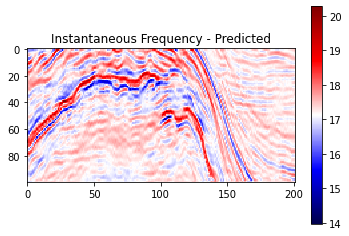

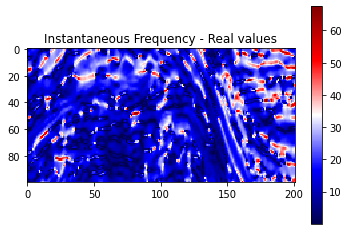

Best Parameters: {'C': 20, 'epsilon': 10}
Best Score: -0.0007931902700774596


In [10]:
from sklearn.svm import LinearSVR

'''
param_grid = {'C': [0.1, 1, 10],
              'epsilon': [0.1, 1, 3]}
'''

#Select a linear model
model = LinearSVR()
print("LinearSVR")

# Define the parameter grid
param_grid = {'C': [0.1, 10, 20],
              'epsilon': [0.1, 3, 10]}

# Initialize GridSearchCV with the model and parameter grid
grid_search_C1M2 = GridSearchCV(estimator = model,
                           param_grid = param_grid,
                           scoring = 'r2',
                           cv = 2)

# Fit the GridSearchCV to the data
grid_search_C1M2.fit(data_train, label_train)
joblib.dump(grid_search_C1M2.best_estimator_, "Regression - C1M2.sav")

# Print the best parameters and best score
y_pred = grid_search_C1M2.best_estimator_.predict(data_train)
plotFacies(y_pred.reshape(150, 201, 100), cmap = "seismic", title = "Instantaneous Frequency - Predicted")
plotFacies(label_train.reshape(150, 201, 100), cmap = "seismic", title = "Instantaneous Frequency - Real values")

print("Best Parameters:", grid_search_C1M2.best_params_)
print("Best Score:", grid_search_C1M2.best_score_)

In [11]:
from sklearn.ensemble import RandomForestRegressor

#Select a linear model
model = RandomForestRegressor()
print("Random Forest Regressor")

# Define the parameter grid
param_grid = {'n_estimators': [5, 10, 20]}

# Initialize GridSearchCV with the model and parameter grid
grid_search_C1M3 = GridSearchCV(estimator = model,
                           param_grid = param_grid,
                           scoring = 'r2',
                           cv = 2)

# Fit the GridSearchCV to the data
grid_search_C1M3.fit(data_train, label_train)
joblib.dump(grid_search_C1M3.best_estimator_, "Regression - C1M3.sav")

# Print the best parameters and best score
y_pred = grid_search_C1M3.best_estimator_.predict(data_train)
plotFacies(y_pred.reshape(150, 201, 100), cmap = "seismic", title = "Instantaneous Frequency - Predicted")
plotFacies(label_train.reshape(150, 201, 100), cmap = "seismic", title = "Instantaneous Frequency - Real values")

print("Best Parameters:", grid_search_C1M3.best_params_)
print("Best Score:", grid_search_C1M3.best_score_)

Random Forest Regressor


OSError: [Errno 28] No space left on device

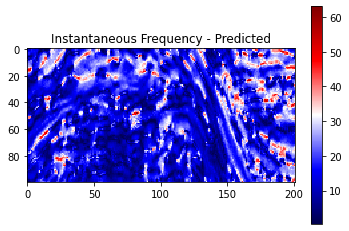

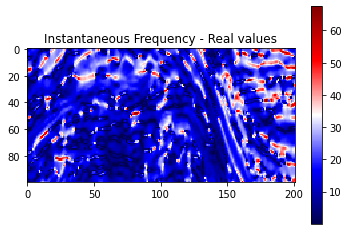

Best Parameters: {'n_estimators': 20}
Best Score: 0.5364871961772812


In [12]:
joblib.dump(grid_search_C1M3.best_estimator_, "Regression - C1M3.sav")

# Print the best parameters and best score
y_pred = grid_search_C1M3.best_estimator_.predict(data_train)
plotFacies(y_pred.reshape(150, 201, 100), cmap = "seismic", title = "Instantaneous Frequency - Predicted")
plotFacies(label_train.reshape(150, 201, 100), cmap = "seismic", title = "Instantaneous Frequency - Real values")

print("Best Parameters:", grid_search_C1M3.best_params_)
print("Best Score:", grid_search_C1M3.best_score_)

### Evaluating

In [13]:
import pprint

pprint.pprint(grid_search_C1M3.cv_results_)

{'mean_fit_time': array([ 72.63230395, 143.82302141, 287.56790638]),
 'mean_score_time': array([ 5.30877244, 10.3968271 , 20.76046658]),
 'mean_test_score': array([0.47202796, 0.51487649, 0.5364872 ]),
 'param_n_estimators': masked_array(data=[5, 10, 20],
             mask=[False, False, False],
       fill_value='?',
            dtype=object),
 'params': [{'n_estimators': 5}, {'n_estimators': 10}, {'n_estimators': 20}],
 'rank_test_score': array([3, 2, 1], dtype=int32),
 'split0_test_score': array([0.47248742, 0.51591575, 0.53830388]),
 'split1_test_score': array([0.4715685 , 0.51383724, 0.53467051]),
 'std_fit_time': array([0.7157681 , 1.38999748, 2.64936829]),
 'std_score_time': array([5.23794889e-02, 6.68764114e-05, 1.62035704e-01]),
 'std_test_score': array([0.00045946, 0.00103926, 0.00181669])}


In [8]:
import joblib
from sklearn.metrics import r2_score

final_model = joblib.load("/Volumes/Seagate/Sandbox/MO810/Regression - C1M3.sav")

#Create a dataframe
data_test = neighbors_4(x_test)
data_test = scaler.transform(data_test)

#Reshape labels array to 1D
label_test = y_test.reshape(-1)

#Predict 
final_predictions = final_model.predict(data_test)
print("Final r2: ", r2_score(label_test, final_predictions))

plotFacies(final_predictions.reshape(50, 201, 100), cmap = "seismic", title = "Instantaneous Frequency - Predicted")
plotFacies(y_test.reshape(50, 201, 100), cmap = "seismic", title = "Instantaneous Frequency - Real values")

Data shape before:  (50, 201, 100)
Neighbors shape:  (1005000, 5)
                0         1         2         3         4
0        0.235239  0.235239  0.235239  0.169178  0.099755
1        0.235239  0.235239  0.169178  0.099755  0.061258
2        0.235239  0.169178  0.099755  0.061258  0.051560
3        0.169178  0.099755  0.061258  0.051560  0.025842
4        0.099755  0.061258  0.051560  0.025842 -0.071678
...           ...       ...       ...       ...       ...
1004995  0.207534  0.228717  0.181259  0.063985 -0.129441
1004996  0.228717  0.181259  0.063985 -0.129441 -0.350321
1004997  0.181259  0.063985 -0.129441 -0.350321 -0.401417
1004998  0.063985 -0.129441 -0.350321 -0.401417 -0.401417
1004999 -0.129441 -0.350321 -0.401417 -0.401417 -0.401417

[1005000 rows x 5 columns]
Final r2:  0.5493111846936358


ValueError: cannot reshape array of size 1005000 into shape (150,201,100)

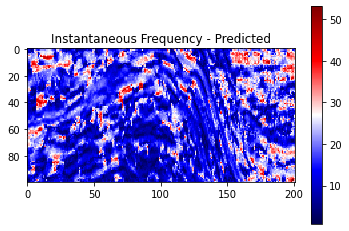

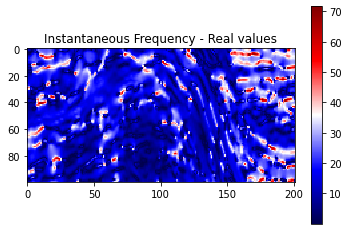

In [9]:
plotFacies(final_predictions.reshape(50, 201, 100), cmap = "seismic", title = "Instantaneous Frequency - Predicted")
plotFacies(y_test.reshape(50, 201, 100), cmap = "seismic", title = "Instantaneous Frequency - Real values")

---

## CASE 2 | Cosine Instantaneous Phase

### Data Processing

In [5]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

#Split train and test set
x_train, x_test, y_train, y_test = train_test_split(seismic_data,
                                                    seismic_cos_inst_phase,
                                                    random_state = 48,
                                                    test_size = 0.25)

#Create a dataframe with the 4 neighbors of the seismic trace and reshape to 1D and 5 features
data_train = neighbors_4(x_train)

#Reshape labels array to 1D
label_train = y_train.reshape(-1)
print("label_train:", label_train.shape)

#Define min max scaler
scaler = MinMaxScaler()                          

#Transform data
data_train = scaler.fit_transform(data_train)

Data shape before:  (150, 201, 100)
Neighbors shape:  (3015000, 5)
                0         1         2         3         4
0       -0.008620 -0.008620 -0.008620  0.087573  0.255171
1       -0.008620 -0.008620  0.087573  0.255171  0.417836
2       -0.008620  0.087573  0.255171  0.417836  0.469510
3        0.087573  0.255171  0.417836  0.469510  0.352117
4        0.255171  0.417836  0.469510  0.352117  0.139526
...           ...       ...       ...       ...       ...
3014995  0.040616  0.171763  0.430611  0.697784  0.800067
3014996  0.171763  0.430611  0.697784  0.800067  0.647740
3014997  0.430611  0.697784  0.800067  0.647740  0.354212
3014998  0.697784  0.800067  0.647740  0.354212  0.354212
3014999  0.800067  0.647740  0.354212  0.354212  0.354212

[3015000 rows x 5 columns]
label_train: (3015000,)


### Models

Linear Regression


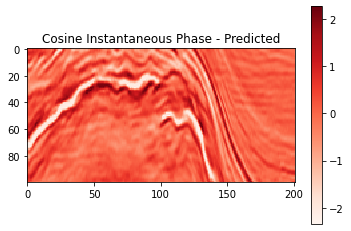

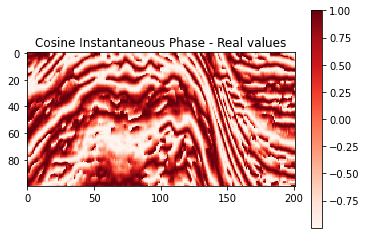

Best Parameters: {'fit_intercept': True}
Best Score: 0.558442737925539


In [6]:
import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

#Select a linear model
model = LinearRegression()
print("Linear Regression")

# Define the parameter grid
param_grid = {'fit_intercept': [True, False]}

# Initialize GridSearchCV with the model and parameter grid
grid_search_C2M1 = GridSearchCV(estimator = model,
                           param_grid = param_grid,
                           scoring = 'r2',
                           cv = 5)

# Fit the GridSearchCV to the data
grid_search_C2M1.fit(data_train, label_train)
joblib.dump(grid_search_C2M1.best_estimator_, "Regression - C2M1.sav")

y_pred = grid_search_C2M1.best_estimator_.predict(data_train)
plotFacies(y_pred.reshape(150, 201, 100), cmap = "Reds", title = "Cosine Instantaneous Phase - Predicted")
plotFacies(label_train.reshape(150, 201, 100), cmap = "Reds", title = "Cosine Instantaneous Phase - Real values")

# Print the best parameters and best score
print("Best Parameters:", grid_search_C2M1.best_params_)
print("Best Score:", grid_search_C2M1.best_score_)

LinearSVR


/Users/felipedias/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/felipedias/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/felipedias/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/felipedias/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


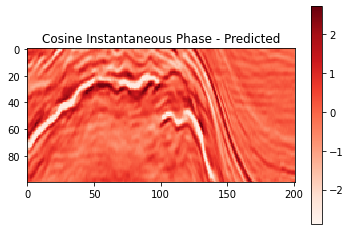

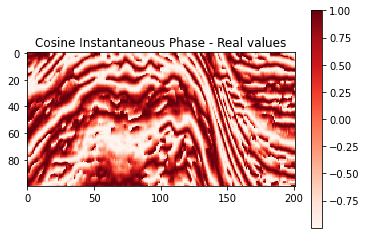

Best Parameters: {'C': 0.1, 'epsilon': 0.1}
Best Score: 0.5314618468014433


In [7]:
from sklearn.svm import LinearSVR

#Select a linear model
model = LinearSVR()
print("LinearSVR")

# Define the parameter grid
param_grid = {'C': [0.1, 10, 20],
              'epsilon': [0.1, 3, 10]}

# Initialize GridSearchCV with the model and parameter grid
grid_search_C2M2 = GridSearchCV(estimator = model,
                           param_grid = param_grid,
                           scoring = 'r2',
                           cv = 2)

# Fit the GridSearchCV to the data
grid_search_C2M2.fit(data_train, label_train)
joblib.dump(grid_search_C2M2.best_estimator_, "Regression - C2M2.sav")

y_pred = grid_search_C2M2.best_estimator_.predict(data_train)
plotFacies(y_pred.reshape(150, 201, 100), cmap = "Reds", title = "Cosine Instantaneous Phase - Predicted")
plotFacies(label_train.reshape(150, 201, 100), cmap = "Reds", title = "Cosine Instantaneous Phase - Real values")

# Print the best parameters and best score
print("Best Parameters:", grid_search_C2M2.best_params_)
print("Best Score:", grid_search_C2M2.best_score_)

Random Forest Regressor


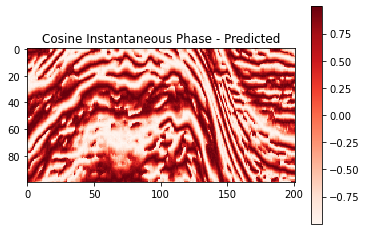

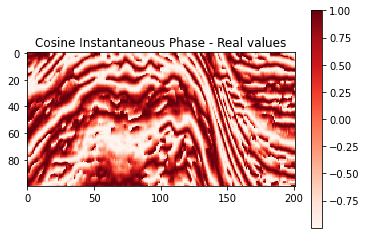

Best Parameters: {'n_estimators': 10}
Best Score: 0.9473230463439586


In [8]:
from sklearn.ensemble import RandomForestRegressor

#Select a linear model
model = RandomForestRegressor()
print("Random Forest Regressor")

# Define the parameter grid
param_grid = {'n_estimators': [5, 10]}

# Initialize GridSearchCV with the model and parameter grid
grid_search_C2M3 = GridSearchCV(estimator = model,
                           param_grid = param_grid,
                           scoring = 'r2',
                           cv = 2)

# Fit the GridSearchCV to the data
grid_search_C2M3.fit(data_train, label_train)
joblib.dump(grid_search_C2M3.best_estimator_, "/Volumes/Seagate/Sandbox/MO810/Regression - C2M3.sav")

y_pred = grid_search_C2M3.best_estimator_.predict(data_train)
plotFacies(y_pred.reshape(150, 201, 100), cmap = "Reds", title = "Cosine Instantaneous Phase - Predicted")
plotFacies(label_train.reshape(150, 201, 100), cmap = "Reds", title = "Cosine Instantaneous Phase - Real values")

# Print the best parameters and best score
print("Best Parameters:", grid_search_C2M3.best_params_)
print("Best Score:", grid_search_C2M3.best_score_)

### Evaluating

In [10]:
import pprint
pprint.pprint(grid_search_C2M3.cv_results_)

{'mean_fit_time': array([ 75.87389791, 151.34631753]),
 'mean_score_time': array([ 5.36339188, 11.52037549]),
 'mean_test_score': array([0.94269363, 0.94732305]),
 'param_n_estimators': masked_array(data=[5, 10],
             mask=[False, False],
       fill_value='?',
            dtype=object),
 'params': [{'n_estimators': 5}, {'n_estimators': 10}],
 'rank_test_score': array([2, 1], dtype=int32),
 'split0_test_score': array([0.94246618, 0.94720887]),
 'split1_test_score': array([0.94292108, 0.94743723]),
 'std_fit_time': array([0.31451809, 0.5810225 ]),
 'std_score_time': array([0.03630209, 0.98528242]),
 'std_test_score': array([0.00022745, 0.00011418])}


Data shape before:  (50, 201, 100)
Neighbors shape:  (1005000, 5)
                0         1         2         3         4
0        0.235239  0.235239  0.235239  0.169178  0.099755
1        0.235239  0.235239  0.169178  0.099755  0.061258
2        0.235239  0.169178  0.099755  0.061258  0.051560
3        0.169178  0.099755  0.061258  0.051560  0.025842
4        0.099755  0.061258  0.051560  0.025842 -0.071678
...           ...       ...       ...       ...       ...
1004995  0.207534  0.228717  0.181259  0.063985 -0.129441
1004996  0.228717  0.181259  0.063985 -0.129441 -0.350321
1004997  0.181259  0.063985 -0.129441 -0.350321 -0.401417
1004998  0.063985 -0.129441 -0.350321 -0.401417 -0.401417
1004999 -0.129441 -0.350321 -0.401417 -0.401417 -0.401417

[1005000 rows x 5 columns]
Final r2:  0.9484538670989768


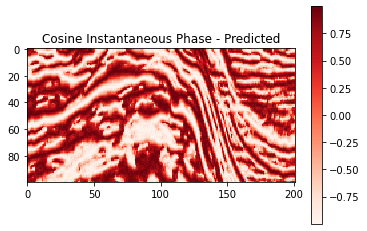

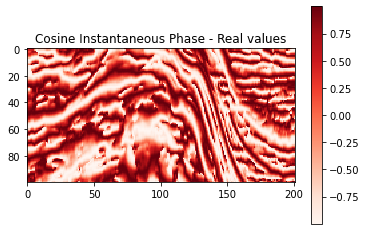

In [7]:
from sklearn.metrics import r2_score
import joblib

final_model = joblib.load("/Volumes/Seagate/Sandbox/MO810/Regression - C2M3.sav")

#Create a dataframe
data_test = neighbors_4(x_test)
data_test = scaler.transform(data_test)

#Reshape labels array to 1D
label_test = y_test.reshape(-1)

#Predict 
final_predictions = final_model.predict(data_test)
print("Final r2: ", r2_score(label_test, final_predictions))

plotFacies(final_predictions.reshape(50, 201, 100), cmap = "Reds", title = "Cosine Instantaneous Phase - Predicted")
plotFacies(y_test.reshape(50, 201, 100), cmap = "Reds", title = "Cosine Instantaneous Phase - Real values")

---

## CASE 3 | Envelope

### Data Preprocessing

In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

#Split train and test set
x_train, x_test, y_train, y_test = train_test_split(seismic_data,
                                                    seismic_envelope,
                                                    random_state = 48,
                                                    test_size = 0.25)

#Create a dataframe with the 4 neighbors of the seismic trace and reshape to 1D and 5 features
data_train = neighbors_4(x_train)

#Reshape labels array to 1D
label_train = y_train.reshape(-1)
print("label_train:", label_train.shape)

#Define min max scaler
scaler = MinMaxScaler()                          

#Transform data
data_train = scaler.fit_transform(data_train)

Data shape before:  (150, 201, 100)
Neighbors shape:  (3015000, 5)
                0         1         2         3         4
0       -0.008620 -0.008620 -0.008620  0.087573  0.255171
1       -0.008620 -0.008620  0.087573  0.255171  0.417836
2       -0.008620  0.087573  0.255171  0.417836  0.469510
3        0.087573  0.255171  0.417836  0.469510  0.352117
4        0.255171  0.417836  0.469510  0.352117  0.139526
...           ...       ...       ...       ...       ...
3014995  0.040616  0.171763  0.430611  0.697784  0.800067
3014996  0.171763  0.430611  0.697784  0.800067  0.647740
3014997  0.430611  0.697784  0.800067  0.647740  0.354212
3014998  0.697784  0.800067  0.647740  0.354212  0.354212
3014999  0.800067  0.647740  0.354212  0.354212  0.354212

[3015000 rows x 5 columns]
label_train: (3015000,)


### Models

Linear Regression


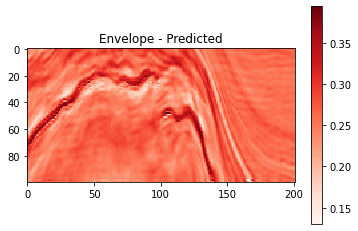

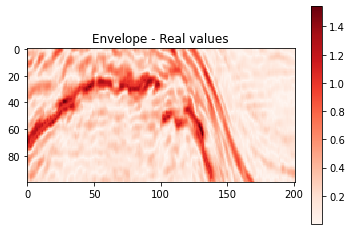

Best Parameters: {'fit_intercept': True}
Best Score: 0.009106010124551011


In [15]:
import joblib
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

#Select a linear model
model = LinearRegression()
print("Linear Regression")

# Define the parameter grid
param_grid = {'fit_intercept': [True, False]}

# Initialize GridSearchCV with the model and parameter grid
grid_search_C3M1 = GridSearchCV(estimator = model,
                           param_grid = param_grid,
                           scoring = 'r2',
                           cv = 5)

# Fit the GridSearchCV to the data
grid_search_C3M1.fit(data_train, label_train)
joblib.dump(grid_search_C3M1.best_estimator_, "Regression - C3M1.sav")

# Print the best parameters and best score
y_pred = grid_search_C3M1.best_estimator_.predict(data_train)
plotFacies(y_pred.reshape(150, 201, 100), cmap = "Reds", title = "Envelope - Predicted")
plotFacies(label_train.reshape(150, 201, 100), cmap = "Reds", title = "Envelope - Real values")

print("Best Parameters:", grid_search_C3M1.best_params_)
print("Best Score:", grid_search_C3M1.best_score_)

LinearSVR


/Users/felipedias/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/Users/felipedias/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


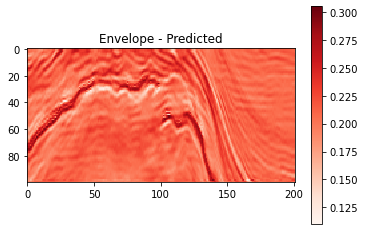

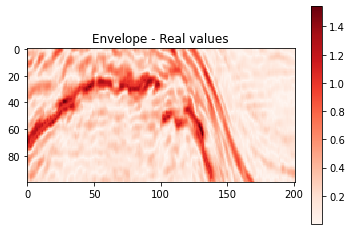

Best Parameters: {'C': 0.1, 'epsilon': 0.1}
Best Score: -0.043014571029660664


In [16]:
from sklearn.svm import LinearSVR

#Select a linear model
model = LinearSVR()
print("LinearSVR")

# Define the parameter grid
param_grid = {'C': [0.1, 10],
              'epsilon': [0.1, 1]}

# Initialize GridSearchCV with the model and parameter grid
grid_search_C3M2 = GridSearchCV(estimator = model,
                           param_grid = param_grid,
                           scoring = 'r2',
                           cv = 2)

# Fit the GridSearchCV to the data
grid_search_C3M2.fit(data_train, label_train)
joblib.dump(grid_search_C3M2.best_estimator_, "Regression - C3M2.sav")

# Print the best parameters and best score
y_pred = grid_search_C3M2.best_estimator_.predict(data_train)
plotFacies(y_pred.reshape(150, 201, 100), cmap = "Reds", title = "Envelope - Predicted")
plotFacies(label_train.reshape(150, 201, 100), cmap = "Reds", title = "Envelope - Real values")

print("Best Parameters:", grid_search_C3M2.best_params_)
print("Best Score:", grid_search_C3M2.best_score_)

Random Forest Regressor


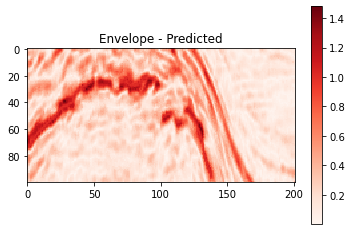

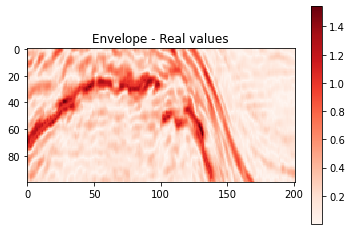

Best Parameters: {'n_estimators': 10}
Best Score: 0.930350602615813


In [17]:
from sklearn.ensemble import RandomForestRegressor

#Select a linear model
model = RandomForestRegressor()
print("Random Forest Regressor")

# Define the parameter grid
param_grid = {'n_estimators': [5, 10]}

# Initialize GridSearchCV with the model and parameter grid
grid_search_C3M3 = GridSearchCV(estimator = model,
                           param_grid = param_grid,
                           scoring = 'r2',
                           cv = 2)

# Fit the GridSearchCV to the data
grid_search_C3M3.fit(data_train, label_train)
joblib.dump(grid_search_C3M3.best_estimator_, "Regression - C3M3.sav")

# Print the best parameters and best score
y_pred = grid_search_C3M3.best_estimator_.predict(data_train)
plotFacies(y_pred.reshape(150, 201, 100), cmap = "Reds", title = "Envelope - Predicted")
plotFacies(label_train.reshape(150, 201, 100), cmap = "Reds", title = "Envelope - Real values")

print("Best Parameters:", grid_search_C3M3.best_params_)
print("Best Score:", grid_search_C3M3.best_score_)

### Evaluating

In [18]:
import pprint
pprint.pprint(grid_search_C3M3.cv_results_)

{'mean_fit_time': array([ 94.59630883, 186.65673256]),
 'mean_score_time': array([ 6.5769546 , 12.29051042]),
 'mean_test_score': array([0.92408487, 0.9303506 ]),
 'param_n_estimators': masked_array(data=[5, 10],
             mask=[False, False],
       fill_value='?',
            dtype=object),
 'params': [{'n_estimators': 5}, {'n_estimators': 10}],
 'rank_test_score': array([2, 1], dtype=int32),
 'split0_test_score': array([0.92549571, 0.93159379]),
 'split1_test_score': array([0.92267403, 0.92910741]),
 'std_fit_time': array([1.87095797, 5.81839037]),
 'std_score_time': array([0.30628252, 0.37539053]),
 'std_test_score': array([0.00141084, 0.00124319])}


Data shape before:  (50, 201, 100)
Neighbors shape:  (1005000, 5)
                0         1         2         3         4
0        0.235239  0.235239  0.235239  0.169178  0.099755
1        0.235239  0.235239  0.169178  0.099755  0.061258
2        0.235239  0.169178  0.099755  0.061258  0.051560
3        0.169178  0.099755  0.061258  0.051560  0.025842
4        0.099755  0.061258  0.051560  0.025842 -0.071678
...           ...       ...       ...       ...       ...
1004995  0.207534  0.228717  0.181259  0.063985 -0.129441
1004996  0.228717  0.181259  0.063985 -0.129441 -0.350321
1004997  0.181259  0.063985 -0.129441 -0.350321 -0.401417
1004998  0.063985 -0.129441 -0.350321 -0.401417 -0.401417
1004999 -0.129441 -0.350321 -0.401417 -0.401417 -0.401417

[1005000 rows x 5 columns]
Final r2:  0.9324525559278599


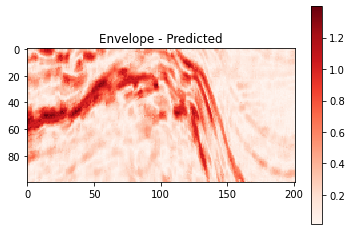

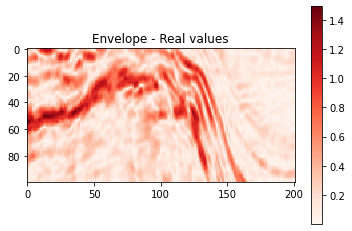

In [9]:
from sklearn.metrics import r2_score

final_model = joblib.load("/Volumes/Seagate/Sandbox/MO810/Regression - C3M3.sav")

#Create a dataframe
data_test = neighbors_4(x_test)
data_test = scaler.transform(data_test)

#Reshape labels array to 1D
label_test = y_test.reshape(-1)

#Predict 
final_predictions = final_model.predict(data_test)
print("Final r2: ", r2_score(label_test, final_predictions))

plotFacies(final_predictions.reshape(50, 201, 100), cmap = "Reds", title = "Envelope - Predicted")
plotFacies(y_test.reshape(50, 201, 100), cmap = "Reds", title = "Envelope - Real values")

## Evaluate with full inline

In [12]:
import numpy as np
import joblib

from sklearn.metrics import r2_score

#Upload data
seismic_data_filename                            = "F3_train.npy"
seismic_attr_instantaneous_frequency_filename    = "F3_train_instantaneous_frequency.npy"
seismic_attr_cosine_instantaneous_phase_filename = "F3_train_cosine_instantaneous_phase.npy"
seismic_attr_envelope_filename                   = "F3_train_envelope.npy"

def filter_data(data): return data[:5,:,:]

# Read the seismic data samples from a NPY file
seismic_data           = filter_data(np.load(seismic_data_filename))
seismic_inst_freq      = filter_data(np.load(seismic_attr_instantaneous_frequency_filename))
seismic_cos_inst_phase = filter_data(np.load(seismic_attr_cosine_instantaneous_phase_filename))
seismic_envelope       = filter_data(np.load(seismic_attr_envelope_filename))

#Create a dataframe
data_test = neighbors_4(seismic_data)
data_test = scaler.transform(data_test)

#Reshape labels array to 1D
inst_freq_test      = seismic_inst_freq.reshape(-1)
cos_inst_phase_test = seismic_cos_inst_phase.reshape(-1)
envelope_test       = seismic_envelope.reshape(-1)

Data shape before:  (5, 701, 255)
Neighbors shape:  (893775, 5)
               0         1         2         3         4
0       0.000000  0.000000  0.000000  0.008296  0.050130
1       0.000000  0.000000  0.008296  0.050130  0.079065
2       0.000000  0.008296  0.050130  0.079065  0.058989
3       0.008296  0.050130  0.079065  0.058989 -0.008284
4       0.050130  0.079065  0.058989 -0.008284 -0.095361
...          ...       ...       ...       ...       ...
893770 -0.032671  0.259947  0.550454  0.716704  0.750235
893771  0.259947  0.550454  0.716704  0.750235  0.735790
893772  0.550454  0.716704  0.750235  0.735790  0.735790
893773  0.716704  0.750235  0.735790  0.735790  0.735790
893774  0.750235  0.735790  0.735790  0.735790  0.735790

[893775 rows x 5 columns]


Instantaneous Frequency
r2 score:  0.5850685439091401


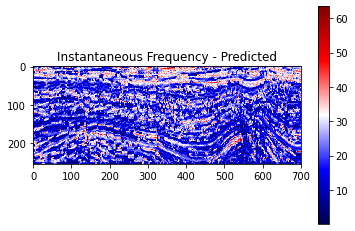

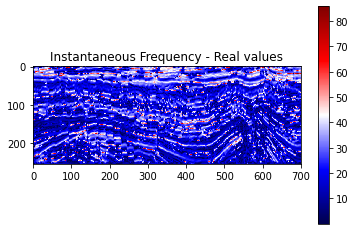

In [14]:
#Predict and Plot graphics
#CASE 1
C1M3 = joblib.load("/Volumes/Seagate/Sandbox/MO810/Regression - C1M3.sav")

C1M3_predictions = C1M3.predict(data_test)
print("Instantaneous Frequency")
print("r2 score: ", r2_score(inst_freq_test, C1M3_predictions))

plotFacies(C1M3_predictions.reshape(5, 701, 255), cmap = "seismic", title = "Instantaneous Frequency - Predicted")
plotFacies(inst_freq_test.reshape(5, 701, 255), cmap = "seismic", title = "Instantaneous Frequency - Real values")

Cos Instantaneous Phase
r2 score:  0.957407715577454


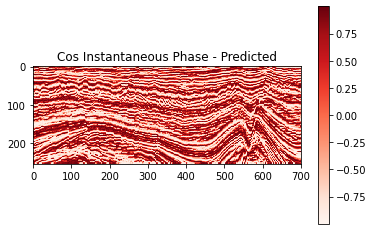

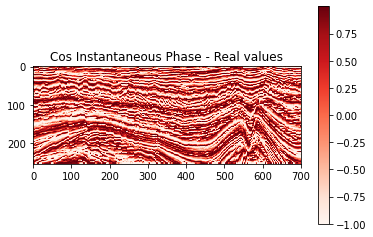

In [15]:
#CASE 2
C2M3 = joblib.load("/Volumes/Seagate/Sandbox/MO810/Regression - C2M3.sav")

C2M3_predictions = C2M3.predict(data_test)
print("Cos Instantaneous Phase")
print("r2 score: ", r2_score(cos_inst_phase_test, C2M3_predictions))

plotFacies(C2M3_predictions.reshape(5, 701, 255), cmap = "Reds", title = "Cos Instantaneous Phase - Predicted")
plotFacies(cos_inst_phase_test.reshape(5, 701, 255), cmap = "Reds", title = "Cos Instantaneous Phase - Real values")

Envelope
r2 score:  0.9144609118277589


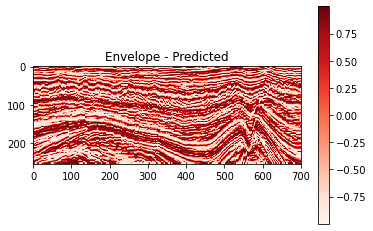

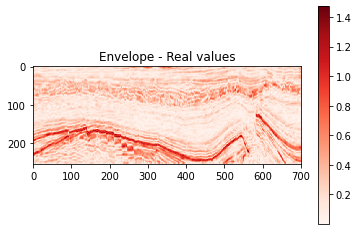

In [16]:
#CASE 3
C3M3 = joblib.load("/Volumes/Seagate/Sandbox/MO810/Regression - C3M3.sav")

C3M3_predictions = C3M3.predict(data_test)
print("Envelope")
print("r2 score: ", r2_score(envelope_test, C3M3_predictions))

plotFacies(C2M3_predictions.reshape(5, 701, 255), cmap = "Reds", title = "Envelope - Predicted")
plotFacies(envelope_test.reshape(5, 701, 255), cmap = "Reds", title = "Envelope - Real values")